# Regression Task

This notebook demonstrates a regression task using machine learning. This is a simple demonstration of regression neural network in PyTorch using a single hidden layer, one output layer and one hidden layer. The polynomials to be learnt are:

1) 2x^2 + 4x + 2
2) 4x^2 + 4x + 10 

raghudiddigi@gmail.com

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [16]:
parameter_importance = {}
new_weights = {}
old_weights = {}

In [17]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.hidden = nn.Linear(1, 64)  # One hidden layer with 10 neurons
        self.relu = nn.ReLU()
        self.output = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [18]:
class Function(ABC):
    @abstractmethod
    def evaluate(self, x: np.ndarray) -> np.ndarray:
        pass

class QuadraticPolynomial(Function):
    def __init__(self, a: float, b: float, c: float):
        self.a = a
        self.b = b
        self.c = c
    
    def evaluate(self, x: np.ndarray) -> np.ndarray:
        return self.a * x**2 + self.b * x + self.c

class CubicPolynomial(Function):
    def __init__(self, a: float, b: float, c: float, d: float):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
    
    def evaluate(self, x: np.ndarray) -> np.ndarray:
        return self.a * x**3 + self.b * x**2 + self.c * x + self.d

In [19]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):   
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [20]:
def custom_loss(model, criterion, outputs, y_data, old_params, param_importance, lambda_reg):
    normal_loss = criterion(outputs, y_data)
    reg_loss = 0.0
    for name, param in model.named_parameters():
        if param.requires_grad:
            reg_loss += torch.sum(param_importance[name] * (param - old_params[name]) ** 2)
    
    total_loss = normal_loss + lambda_reg * reg_loss
    return total_loss


In [21]:
def train_model(model,x_train,y_train,num_epochs,optimizer,device):
    losses = []
    global new_weights
    global old_weights
    old_weights = new_weights
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
    # Forward pass
        outputs = model(x_train.to(device))
        loss = criterion(outputs, y_train.to(device))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
            print()
    
    new_weights = {name: param.clone().detach() for name, param in model.named_parameters()}
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()


In [22]:
def train_model_with_custom_loss(model,x_train,y_train,num_epochs,optimizer,device):
    losses = []
    global new_weights
    global old_weights
    old_weights = new_weights
    for epoch in range(num_epochs):
    # Forward pass
        outputs = model(x_train.to(device))
        loss = custom_loss(model,nn.MSELoss(),outputs,y_train.to(device),old_weights,parameter_importance,100)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
            print()
    
    new_weights = {name: param.clone().detach() for name, param in model.named_parameters()}
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

In [23]:
def get_predict_data(x_train_1, y_train_1, x_train_2, y_train_2, x_train_3, y_train_3):

    # Initialize x_test and y_test
    x_test = torch.tensor([])
    y_test = torch.tensor([])

    # Randomly sample 200 samples
    indices = torch.randperm(x_train_1.size(0))[:200]

    x_sample = x_train_1[indices]
    y_sample = y_train_1[indices]

    # Append to x_test and y_test
    x_test = torch.cat((x_test, x_sample))
    y_test = torch.cat((y_test, y_sample))

    indices = torch.randperm(x_train_2.size(0))[:200]

    x_sample = x_train_2[indices]
    y_sample = y_train_2[indices]  

    x_test = torch.cat((x_test, x_sample))
    y_test = torch.cat((y_test, y_sample))

    indices = torch.randperm(x_train_3.size(0))[:200]

    x_sample = x_train_3[indices]
    y_sample = y_train_3[indices]  

    x_test = torch.cat((x_test, x_sample))
    y_test = torch.cat((y_test, y_sample))
    
    return x_test, y_test

In [24]:
def evaluate_model(model, x_test, device):

    model.eval()
    x_test = x_test.to(device)
    model.to(device)

    outputs = model(x_test)
    y_pred = outputs.detach().cpu().numpy()
    return y_pred

def get_average_polynomial(x_test, f1:Function, f2:Function, f3:Function):

    x_test = x_test.cpu().numpy()
    return f1.evaluate(x_test)/3 + f2.evaluate(x_test)/3 + f3.evaluate(x_test)/3

In [25]:
np.random.seed(42)
x = np.random.uniform(-10, 10, 1000)

f1 = QuadraticPolynomial(2, 4, 2)
y = f1.evaluate(x)
x_train_1 = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_train_1 = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  

x = np.random.uniform(-10, 10, 1000)
f2 =  QuadraticPolynomial(4, 4, 10)
y = f2.evaluate(x)
x_train_2 = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  
y_train_2 = torch.tensor(y, dtype=torch.float32).unsqueeze(1) 

x = np.random.uniform(-10, 10, 1000)
f3 = QuadraticPolynomial(6, 7, 9)
y = f3.evaluate(x)
x_train_3 = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_train_3 = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  

x_test, y_test = get_predict_data(x_train_1, y_train_1, x_train_2, y_train_2, x_train_3, y_train_3)
f_avg = get_average_polynomial(x_test, f1, f2, f3)

cuda
Epoch [1000/20000], Loss: 481.6839

Epoch [2000/20000], Loss: 298.0824

Epoch [3000/20000], Loss: 153.8433

Epoch [4000/20000], Loss: 73.6296

Epoch [5000/20000], Loss: 36.5342

Epoch [6000/20000], Loss: 16.7849

Epoch [7000/20000], Loss: 7.1863

Epoch [8000/20000], Loss: 2.7018

Epoch [9000/20000], Loss: 0.9561

Epoch [10000/20000], Loss: 0.3370

Epoch [11000/20000], Loss: 0.1273

Epoch [12000/20000], Loss: 0.0555

Epoch [13000/20000], Loss: 0.0248

Epoch [14000/20000], Loss: 0.0115

Epoch [15000/20000], Loss: 0.0062

Epoch [16000/20000], Loss: 0.0035

Epoch [17000/20000], Loss: 0.0026

Epoch [18000/20000], Loss: 0.0020

Epoch [19000/20000], Loss: 0.0017

Epoch [20000/20000], Loss: 0.0016



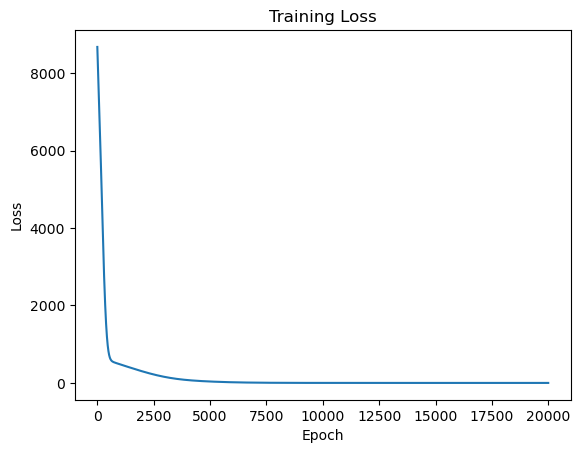

In [26]:
dataset = CustomDataset(x_train_1, y_train_1)
dataloader_1 =DataLoader(dataset, batch_size=32, shuffle=True)  

model_1 = RegressionModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)
print(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

# Train the model_1
num_epochs = 20000
train_model(model_1,x_train_1,y_train_1,num_epochs,optimizer,device)

# Save the trained model
torch.save(model_1.state_dict(), "model_1.pth")
y_pred_1 = evaluate_model(model_1, x_test, device)

cuda


Epoch [1000/20000], Loss: 2200.3000

Epoch [2000/20000], Loss: 1637.3158

Epoch [3000/20000], Loss: 1136.1533

Epoch [4000/20000], Loss: 701.8059

Epoch [5000/20000], Loss: 392.6118

Epoch [6000/20000], Loss: 208.7757

Epoch [7000/20000], Loss: 101.5211

Epoch [8000/20000], Loss: 45.0075

Epoch [9000/20000], Loss: 19.6221

Epoch [10000/20000], Loss: 7.8397

Epoch [11000/20000], Loss: 2.6996

Epoch [12000/20000], Loss: 1.0072

Epoch [13000/20000], Loss: 0.4068

Epoch [14000/20000], Loss: 0.1563

Epoch [15000/20000], Loss: 0.0657

Epoch [16000/20000], Loss: 0.0288

Epoch [17000/20000], Loss: 0.0132

Epoch [18000/20000], Loss: 0.0071

Epoch [19000/20000], Loss: 0.0042

Epoch [20000/20000], Loss: 0.0031



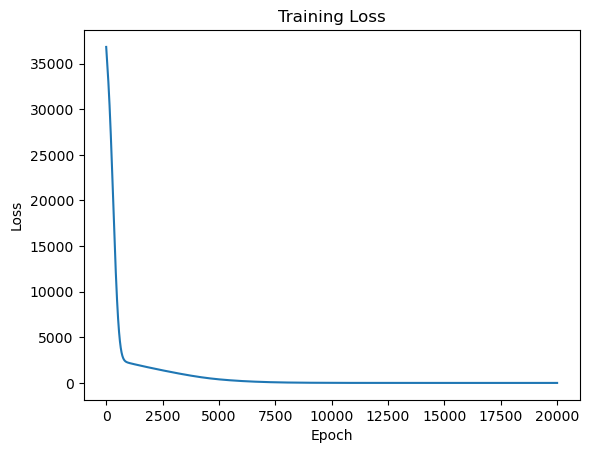

In [27]:
dataset = CustomDataset(x_train_2, y_train_2)
dataloader_2 =DataLoader(dataset, batch_size=32, shuffle=True)

model_2 = RegressionModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)
print(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

# Train the model_2
num_epochs = 20000
train_model(model_2,x_train_2,y_train_2,num_epochs,optimizer,device)
torch.save(model_2.state_dict(), "model_2.pth")
y_pred_2 = evaluate_model(model_2, x_test, device)

cuda


Epoch [1000/20000], Loss: 5833.2334

Epoch [2000/20000], Loss: 4202.5742

Epoch [3000/20000], Loss: 3137.8767

Epoch [4000/20000], Loss: 2156.0625

Epoch [5000/20000], Loss: 1341.1560

Epoch [6000/20000], Loss: 779.6949

Epoch [7000/20000], Loss: 445.3847

Epoch [8000/20000], Loss: 233.4846

Epoch [9000/20000], Loss: 109.9248

Epoch [10000/20000], Loss: 46.4674

Epoch [11000/20000], Loss: 18.8375

Epoch [12000/20000], Loss: 6.5510

Epoch [13000/20000], Loss: 2.2569

Epoch [14000/20000], Loss: 0.9132

Epoch [15000/20000], Loss: 0.4205

Epoch [16000/20000], Loss: 0.1959

Epoch [17000/20000], Loss: 0.0836

Epoch [18000/20000], Loss: 0.0349

Epoch [19000/20000], Loss: 0.0169

Epoch [20000/20000], Loss: 0.0093



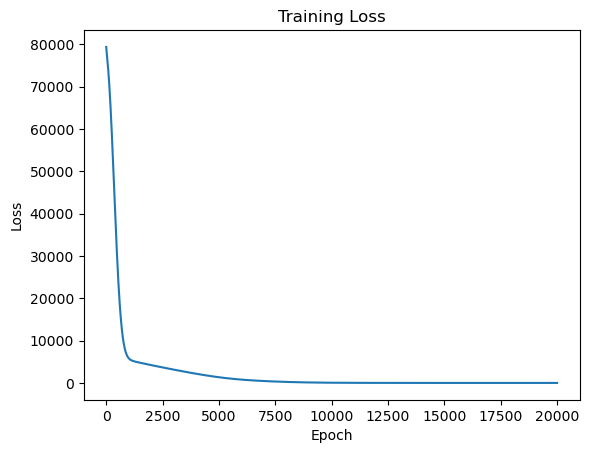

In [28]:
dataset = CustomDataset(x_train_3, y_train_3)
dataloader_3 =DataLoader(dataset, batch_size=32, shuffle=True)

model_3 = RegressionModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_3.to(device)
print(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

# Train the model_3
num_epochs = 20000

train_model(model_3,x_train_3,y_train_3,num_epochs,optimizer,device)
torch.save(model_3.state_dict(), "model_3.pth")
y_pred_3 = evaluate_model(model_3, x_test, device)

In [29]:
model_4 = RegressionModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_4.to(device)
print(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_4.parameters(), lr=0.001)

# Train the model_2
num_epochs = 20000

cuda


In [30]:
def calculate_importance_weights(model, x_data, y_data, parameter_importance):
    x_data = x_data.to(device)
    y_data = y_data.to(device)
    model.to(device)

    outputs = model(x_data)
    loss = criterion(outputs, y_data)

    optimizer.zero_grad()

    loss.backward()
    for name, param in model.named_parameters():
        if param.grad is not None:
            if name in parameter_importance:
                parameter_importance[name] += abs(param.grad.clone().detach())
            else:
                parameter_importance[name] = abs(param.grad.clone().detach())
    
    return parameter_importance


In [31]:
def update_param_importance(model, dataloader, parameter_importance):
    for batch in dataloader:
        x_data, y_data = batch
        parameter_importance = calculate_importance_weights(model, x_data, y_data, parameter_importance)

    for keys,values in parameter_importance.items():
        values = values/len(dataloader)


In [32]:
def plot_preds(x_test, y_test, y_pred_1, y_pred_2, y_pred_3, y_pred_4):

    plt.figure(figsize=(10, 6))

    # Scatter plot for original data
    plt.scatter(x_test.cpu().numpy(), y_test.cpu().numpy(), label="Original Data", color="blue", alpha=0.6)

    # Model predictions - Use scatter instead of plot
    plt.scatter(x_test.cpu().numpy(), y_pred_1, label="Model 1 Prediction", color="red", alpha=0.6)
    plt.scatter(x_test.cpu().numpy(), y_pred_2, label="Model 2 Prediction", color="green", alpha=0.6)
    plt.scatter(x_test.cpu().numpy(), y_pred_3, label="Model 3 Prediction", color="orange", alpha=0.6)
    plt.scatter(x_test.cpu().numpy(), y_pred_4, label="Model 4 Prediction", color="purple", alpha=0.6)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title("Model Predictions vs Original Data")
    plt.show()

    # Calculating Mean Squared Error for each model
    mse_1 = np.mean((y_pred_1 - y_test.cpu().numpy())**2)
    mse_2 = np.mean((y_pred_2 - y_test.cpu().numpy())**2)
    mse_3 = np.mean((y_pred_3 - y_test.cpu().numpy())**2)
    mse_4 = np.mean((y_pred_4 - y_test.cpu().numpy())**2)

    print(f"Model 1 MSE: {mse_1:.4f}")
    print(f"Model 2 MSE: {mse_2:.4f}")
    print(f"Model 3 MSE: {mse_3:.4f}")
    print(f"Model 4 MSE: {mse_4:.4f}")

In [33]:
def plot_preds_new(x_test, y_test, y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_avg):

    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    models = [
        (y_pred_1, "Model 1 Prediction", "red"),
        (y_pred_2, "Model 2 Prediction", "green"),
        (y_pred_3, "Model 3 Prediction", "orange"),
        (y_pred_4, "Model 4 Prediction", "purple"),
    ]

    x_vals = x_test.cpu().numpy()
    y_vals = y_test.cpu().numpy()
    # y_avg = 4 * x_vals**2 + 5 * x_vals + 7  # Defined function

    for i, (y_pred, title, color) in enumerate(models):
        axes[i].scatter(x_vals, y_vals, label="Original Data", color="blue", alpha=0.6)
        axes[i].scatter(x_vals, y_pred, label=title, color=color)
        axes[i].scatter(x_vals, y_avg, label="y_avg Function", color="pink")  # Added y_avg
        axes[i].set_title(title)
        axes[i].legend()
        axes[i].set_xlabel("x")
        axes[i].set_ylabel("y")

    plt.suptitle("Model Predictions vs Original Data (Including y_avg)")
    plt.tight_layout()
    plt.show()

In [41]:
def evaluate_average(y_pred_1, y_pred_2, y_pred_3, y_pred_4, f_avg):

    y_avg = y_pred_1/3 + y_pred_2/3 + y_pred_3/3

    mse_separate = np.mean((y_avg - f_avg)**2)
    mse_model = np.mean((y_pred_4 - f_avg)**2)

    print(f"MSE with average of all models - {mse_separate}")
    print(f"MSE with our model - {mse_model}")

    return y_avg

Epoch [1000/20000], Loss: 471.4576

Epoch [2000/20000], Loss: 293.6880

Epoch [3000/20000], Loss: 148.0327

Epoch [4000/20000], Loss: 66.2830

Epoch [5000/20000], Loss: 31.1226

Epoch [6000/20000], Loss: 13.3697

Epoch [7000/20000], Loss: 4.9767

Epoch [8000/20000], Loss: 1.8165

Epoch [9000/20000], Loss: 0.6713

Epoch [10000/20000], Loss: 0.2491

Epoch [11000/20000], Loss: 0.1002

Epoch [12000/20000], Loss: 0.0443

Epoch [13000/20000], Loss: 0.0192

Epoch [14000/20000], Loss: 0.0093

Epoch [15000/20000], Loss: 0.0053

Epoch [16000/20000], Loss: 0.0037

Epoch [17000/20000], Loss: 0.0025

Epoch [18000/20000], Loss: 0.0022

Epoch [19000/20000], Loss: 0.0019

Epoch [20000/20000], Loss: 0.0018



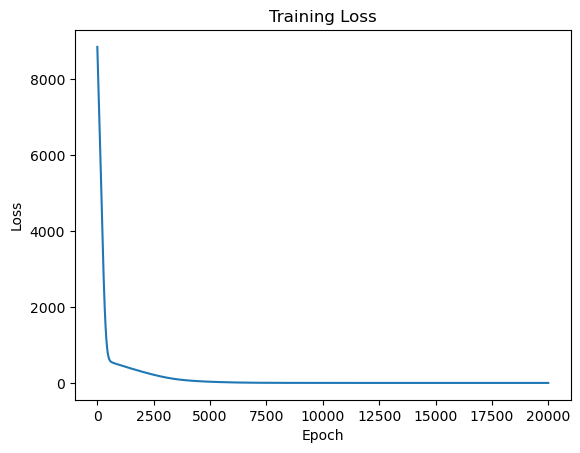

In [35]:
train_model(model_4,x_train_1,y_train_1,num_epochs,optimizer,device)
update_param_importance(model_4, dataloader_1, parameter_importance)

MSE with average of all models - 0.0024134402628988028
MSE with our model - 9527.330078125


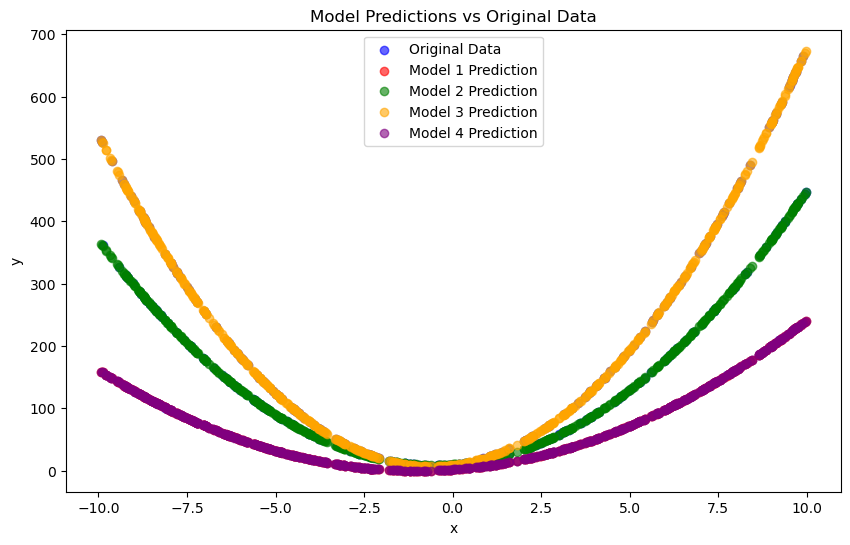

Model 1 MSE: 15937.2715
Model 2 MSE: 6537.4893
Model 3 MSE: 15560.8652
Model 4 MSE: 15934.4531


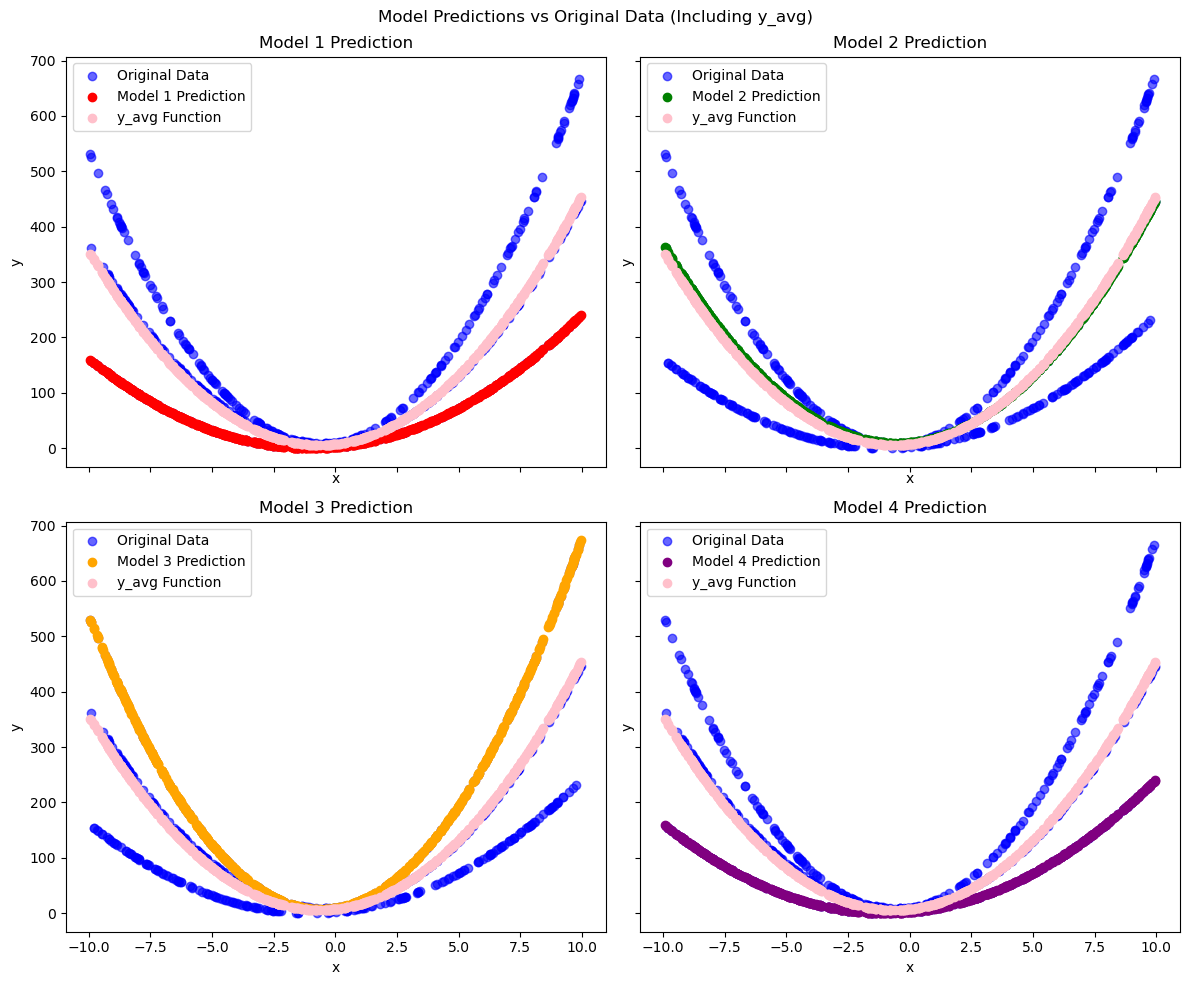

In [42]:
y_pred_4 = evaluate_model(model_4, x_test, device)
y_avg = evaluate_average(y_pred_1, y_pred_2, y_pred_3, y_pred_4, f_avg)

plot_preds(x_test, y_test, y_pred_1, y_pred_2, y_pred_3, y_pred_4)
plot_preds_new(x_test, y_test, y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_avg)

Epoch [1000/20000], Loss: 1397.9949

Epoch [2000/20000], Loss: 1341.7324

Epoch [3000/20000], Loss: 1315.6167

Epoch [4000/20000], Loss: 1306.3197

Epoch [5000/20000], Loss: 1303.2988

Epoch [6000/20000], Loss: 1302.1487

Epoch [7000/20000], Loss: 1301.9020

Epoch [8000/20000], Loss: 1301.8660

Epoch [9000/20000], Loss: 1301.8649

Epoch [10000/20000], Loss: 1301.8649

Epoch [11000/20000], Loss: 1301.8649

Epoch [12000/20000], Loss: 1301.8647

Epoch [13000/20000], Loss: 1301.8647

Epoch [14000/20000], Loss: 1301.8673

Epoch [15000/20000], Loss: 1301.8658

Epoch [16000/20000], Loss: 1301.8649

Epoch [17000/20000], Loss: 1301.8650

Epoch [18000/20000], Loss: 1301.8654

Epoch [19000/20000], Loss: 1301.8651

Epoch [20000/20000], Loss: 1301.8649



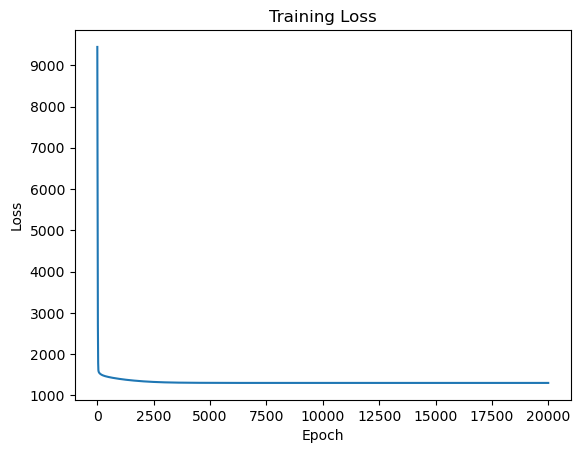

In [43]:
train_model_with_custom_loss(model_4,x_train_2,y_train_2,num_epochs,optimizer,device)
update_param_importance(model_4, dataloader_2, parameter_importance)

MSE with average of all models - 0.0024134402628988028
MSE with our model - 95.34757232666016


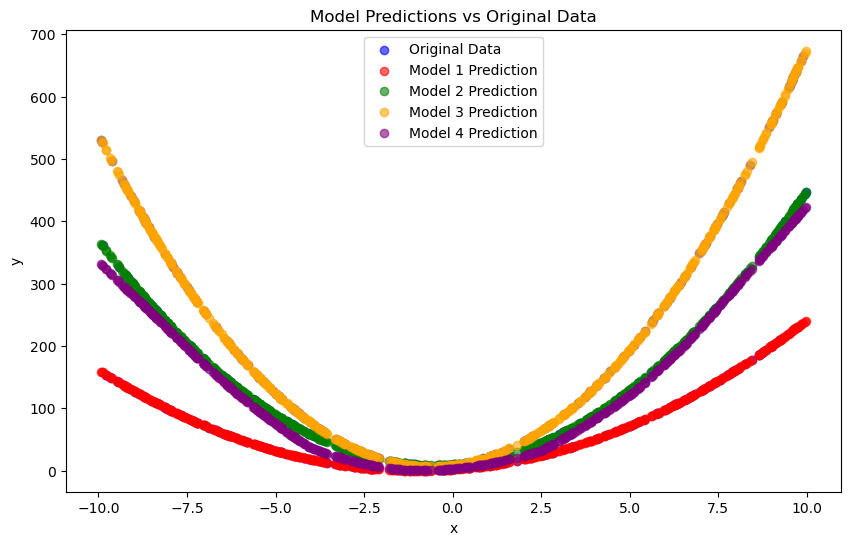

Model 1 MSE: 15937.2715
Model 2 MSE: 6537.4893
Model 3 MSE: 15560.8652
Model 4 MSE: 6625.0015


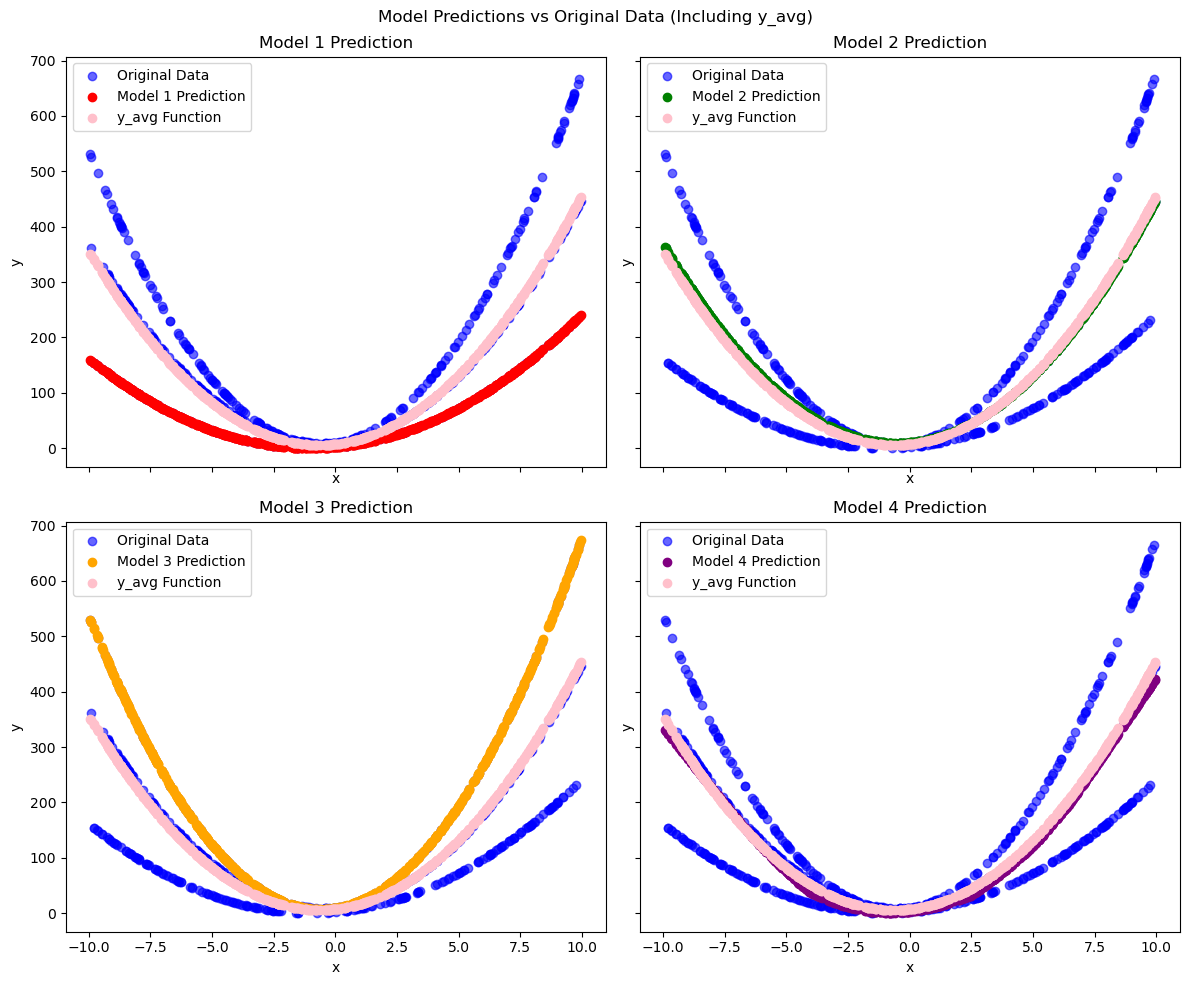

In [45]:
y_pred_4 = evaluate_model(model_4, x_test, device)
y_avg = evaluate_average(y_pred_1, y_pred_2, y_pred_3, y_pred_4, f_avg)

plot_preds(x_test, y_test, y_pred_1, y_pred_2, y_pred_3, y_pred_4)
plot_preds_new(x_test, y_test, y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_avg)

Epoch [1000/20000], Loss: 10031.3545

Epoch [2000/20000], Loss: 10031.3555

Epoch [3000/20000], Loss: 10031.3545

Epoch [4000/20000], Loss: 10031.3809

Epoch [5000/20000], Loss: 10031.3643

Epoch [6000/20000], Loss: 10031.3789

Epoch [7000/20000], Loss: 10031.4102

Epoch [8000/20000], Loss: 10031.3779

Epoch [9000/20000], Loss: 10031.3760

Epoch [10000/20000], Loss: 10031.3750

Epoch [11000/20000], Loss: 10031.3652

Epoch [12000/20000], Loss: 10031.4062

Epoch [13000/20000], Loss: 10031.3701

Epoch [14000/20000], Loss: 10031.3779

Epoch [15000/20000], Loss: 10031.3613

Epoch [16000/20000], Loss: 10031.3770

Epoch [17000/20000], Loss: 10031.3613

Epoch [18000/20000], Loss: 10031.3711

Epoch [19000/20000], Loss: 10031.3682

Epoch [20000/20000], Loss: 10031.3877



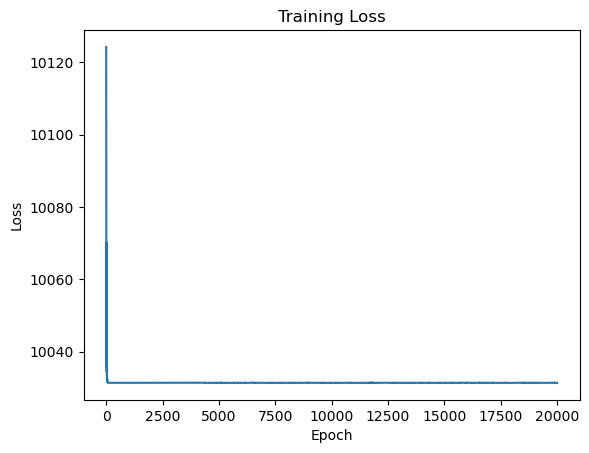

In [46]:
train_model_with_custom_loss(model_4,x_train_3,y_train_3,num_epochs,optimizer,device)

MSE with average of all models - 0.0024134402628988028
MSE with our model - 81.55888366699219


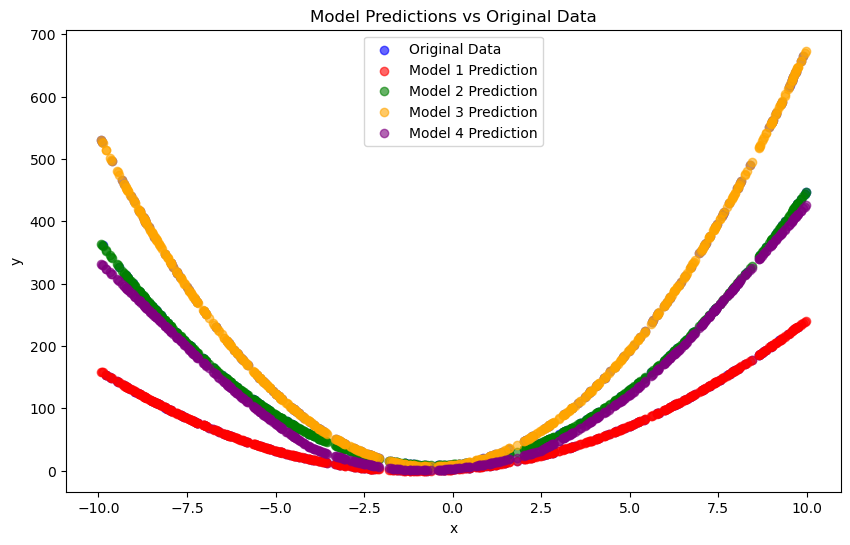

Model 1 MSE: 15937.2715
Model 2 MSE: 6537.4893
Model 3 MSE: 15560.8652
Model 4 MSE: 6609.3481


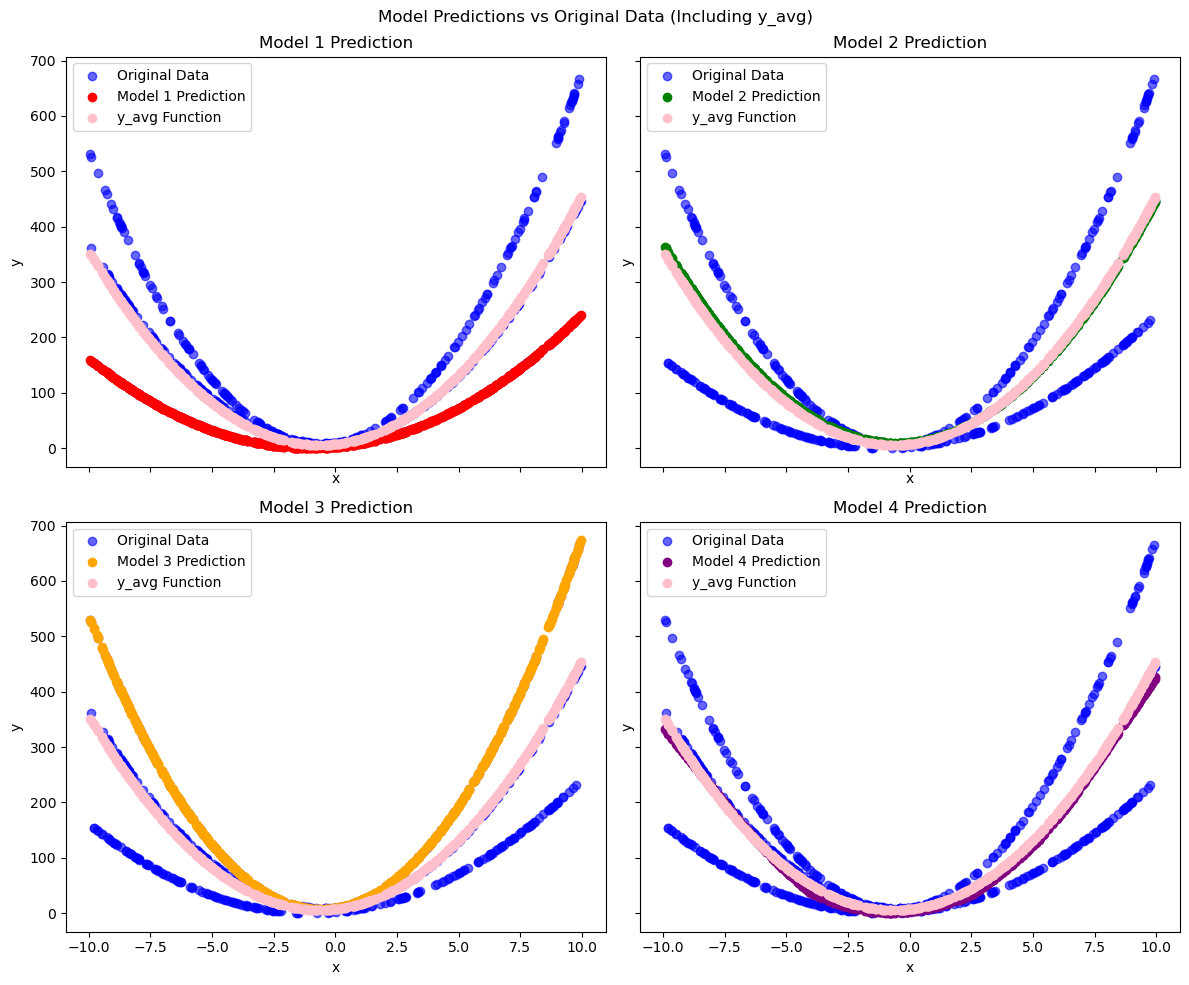

In [47]:
y_pred_4 = evaluate_model(model_4, x_test, device)
y_avg = evaluate_average(y_pred_1, y_pred_2, y_pred_3, y_pred_4, f_avg)

plot_preds(x_test, y_test, y_pred_1, y_pred_2, y_pred_3, y_pred_4)
plot_preds_new(x_test, y_test, y_pred_1, y_pred_2, y_pred_3, y_pred_4, y_avg)